# Biological Data Final Project

This notebook tests multiple models for predicting the function of proteins. The objective is to try different models for each of the 3 Gene Ontologies (Cellular Component, Molecular Function, Biological Processes), and choose the model which performs the best in predicting the function, i.e. GO term ID. Models are evaluated based on precision, accuracy, and F1 score.

## The Data

Training data contains these files:
*   train_set.tsv : The proteins, their Gene Ontology (GO) annotations and their corresponding aspects are given to you in a tab separated file. The GO annotations that are given for each protein are already propagated to the root of ontology.
*   train_ids.txt: This file contains the accession IDs of the proteins that are given to you. It contains about 123k proteins. You may use all or a subset of them in the training.
*   train.fasta: This file contains the sequence of the train proteins in fasta format.
*   train_embeddings.h5 : This file contains ProtT5 embeddings for each protein in the train set.

Note: there are about 123,969 proteins in the training set, thus depending on the models chosen for testing only a subset of the data may be used as it may be hard on computational resources.

## Importing Required Libraries

In [ ]:
!pip install h5py

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
print("TensorFlow v" + tf.__version__)
print("Numpy v" + np.__version__)

TensorFlow v2.15.0
Numpy v1.25.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#%%capture
!unzip '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/biological_data_pfp.zip'

Archive:  /content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/biological_data_pfp.zip
   creating: biological_data_pfp/
   creating: biological_data_pfp/train/
  inflating: biological_data_pfp/train/train_set.tsv  
  inflating: biological_data_pfp/train/train.fasta  
  inflating: biological_data_pfp/train/train_embeddings.h5  
  inflating: biological_data_pfp/train/train_protein2ipr.dat  
  inflating: biological_data_pfp/train/train_ids.txt  
  inflating: biological_data_pfp/train/go-basic.obo  
   creating: biological_data_pfp/test/
  inflating: biological_data_pfp/test/test_embeddings.h5  
  inflating: biological_data_pfp/test/test_ids.txt  
  inflating: biological_data_pfp/test/blast_test_results.tsv  
  inflating: biological_data_pfp/test/test_protein2ipr.dat  
  inflating: biological_data_pfp/test/test.fasta  
   creating: biological_data_pfp/baseline/
   creating: biological_data_pfp/baseline/baseline_preds/
  inflating: biological_data_pfp/baseline/baseline_preds/

## Loading protein terms

First we will load the file `train_terms.tsv` which contains the list of annotated terms (functions) for the proteins. We will extract the labels aka `GO term ID` and create a label dataframe for the protein embeddings.

In [ ]:
train_terms = pd.read_csv("/content/biological_data_pfp/train/train_set.tsv",sep="\t")
print(train_terms.shape)

(4277047, 3)


`train_terms` dataframe is composed of 3 columns (Protein_ID, aspect, GO_term) and 4,277,047 entries.

We can inspect the dataset by printing out the first 5 entries of the dataframe. The first entry of `train_terms.tsv`, has protein id `P91124`, aspect `cellular_component` and the GO term `GO:0005575`. We also notice that the next 4 entries are the same protein with the same aspect but different GO terms, thus it is clear that one protein can have many function labels.

In [ ]:
train_terms.head()

,Protein_ID,aspect,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


## Visualizing the Data

Let's plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

In [ ]:
len(train_terms['GO_term'].unique())

3004

<ipython-input-25-525d010f2414>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(ax=axis, x=np.array(GOterms_100.index), y=GOterms_100.values, palette=colors_list)
<ipython-input-25-525d010f2414>:17: UserWarning: The palette list has more values (3004) than needed (100), which may not be intended.
  bp = sns.barplot(ax=axis, x=np.array(GOterms_100.index), y=GOterms_100.values, palette=colors_list)
<ipython-input-25-525d010f2414>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)


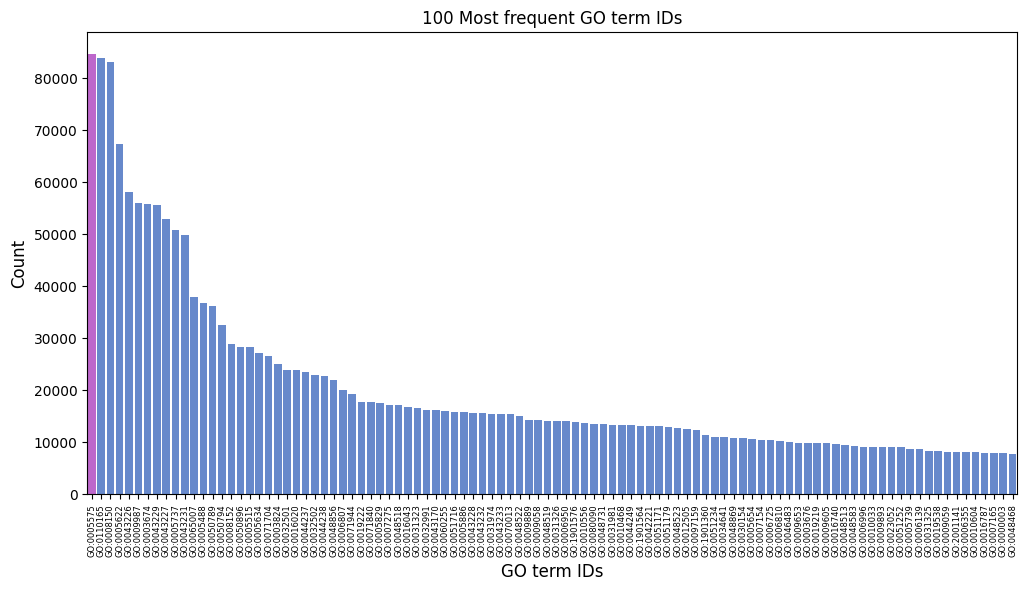

In [ ]:
# Select first 100 values for plotting
GOterms = train_terms['GO_term'].value_counts()
GOterms_100 = train_terms['GO_term'].value_counts().iloc[:100]

#Calculate percentiles
percentiles = np.percentile(GOterms.values, [25, 50, 75, 100])

# Define colors for each percentile range
colors = sns.color_palette("hls", 5)

# Assign colors to bars based on their percentiles
percentile_list = np.digitize(GOterms.values, percentiles)
colors_list = [colors[i] for i in percentile_list]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(GOterms_100.index), y=GOterms_100.values, palette=colors_list)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('100 Most frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.savefig('100 Most frequent GO term IDs')
plt.show()

As specified in the project, to limit prediction file sizes, one target cannot be associated with more than 1500 terms for MF, BP and CC sub ontologies combined. Thus the first 1500 most frequent `GO_terms` will be extracted and saved into a list.

In [ ]:
# Calculate the cumulative sum of the counts of the first 100 GO term IDs
cumulative_sum = GOterms.values.cumsum()

# Calculate the total count of all GO term IDs
total_count = cumulative_sum[-1]

# Calculate the percentage covered by the first 100 GO term IDs
percentage_covered = (cumulative_sum[1499] / total_count) * 100

print(f"The first 1500 GO term IDs cover {percentage_covered:.2f}% of the data.")


The first 1500 GO term IDs cover 93.59% of the data.


In [ ]:
# Set the limit for label
num_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['GO_term'].value_counts().index[:num_labels].tolist()

## Preparing the Dataset
As the 3 branches of the Gene Ontology are non-overlapping, we will separate the dataset and train each branch separately.

In [ ]:
BP_train_df = pd.read_pickle('/content/bio_data/train_embeddings_BiologicalProcesses.pkl')
CC_train_df = pd.read_pickle('/content/bio_data/train_embeddings_CellularComponent.pkl')
MF_train_df = pd.read_pickle('/content/bio_data/train_embeddings_MolecularFunction.pkl')

In [ ]:
BP_label_df = pd.read_pickle('/content/bio_data/train_labels_BiologicalProcesses.pkl')
CC_label_df = pd.read_pickle('/content/bio_data/train_labels_CellularComponent.pkl')
MF_label_df = pd.read_pickle('/content/bio_data/train_labels_MolecularFunction.pkl')

## Loading the best models

The best models obtained from testing were the feed forward neural networks. In each case, the best model had 2 dense hidden layers and the relu activation function for each layer

For biological processes the F1 score obtained was 0.46873.

For molecular function the F1 score obtained was 0.52399.

For cellular component thhe F1 score obtained was 0.50483.

We will now load these best models and use them on the test set.

In [ ]:
# load models
best_BP_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/bio_data/FFNNMod1/best_BP_model'
)

best_MF_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/bio_data/FFNNMod1/best_MF_model'
)

best_CC_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/bio_data/FFNNMod2/best_CC_model'
)

## Testing the models

For testing we use the test embeddings provided in the specification of the project

In [ ]:
hf_test = h5py.File('/content/biological_data_pfp/test/test_embeddings.h5', 'r')
hf_test_dsets = list(hf_test.keys())
len(hf_test_dsets)

In [ ]:
loa_test = []
for key in hf_test_dsets:
  arr = np.array(hf_test[key])
  loa_test.append(arr)

After converting to a dataframe, the `test_embed_df` will be composed of 1024 columns and 1000 entries.

In [ ]:
test_embed_df = pd.DataFrame(loa_test)
print(test_embed_df.shape)
test_embed_df.head()

We will now use the model to make predictions on the test embeddings.
These predictions will be a vector with the probability that the particukar protein belongs to a specific GO term (i.e. has a particular function).

In [ ]:
BP_predictions =  best_BP_model.predict(test_embed_df)
MF_predictions =  best_MF_model.predict(test_embed_df)
CC_predictions =  best_CC_model.predict(test_embed_df)

In [ ]:
test_protein_ids = np.loadtxt('/content/biological_data_pfp/test/test_ids.txt', dtype = str)


### Prediction probabilities for Biological Processes

In [ ]:
BP_df_preds = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])

lst_Protein_IDs = []
for Protein_ID in list(test_protein_ids):
    lst_Protein_IDs += [Protein_ID] * BP_predictions.shape[1]

BP_df_preds['Protein Id'] = lst_Protein_IDs
BP_df_preds['GO Term Id'] = labels * BP_predictions.shape[0]
BP_df_preds['Prediction'] = BP_predictions.ravel()
BP_df_preds.to_csv("BioProcesses_Predictions.tsv",header=False, index=False, sep="\t")

### Prediction probabilities for Molecular Function

In [ ]:
MF_df_preds = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])

lst_Protein_IDs = []
for Protein_ID in list(test_protein_ids):
    lst_Protein_IDs += [Protein_ID] * MF_predictions.shape[1]

MF_df_preds['Protein Id'] = lst_Protein_IDs
MF_df_preds['GO Term Id'] = labels * MF_predictions.shape[0]
MF_df_preds['Prediction'] = MF_predictions.ravel()
MF_df_preds.to_csv("MolecularFunction_Predictions.tsv",header=False, index=False, sep="\t")

### Prediction probabilities for Cellular Component

In [ ]:
CC_df_preds = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])

lst_Protein_IDs = []
for Protein_ID in list(test_protein_ids):
    lst_Protein_IDs += [Protein_ID] * CC_predictions.shape[1]

CC_df_preds['Protein Id'] = lst_Protein_IDs
CC_df_preds['GO Term Id'] = labels * CC_predictions.shape[0]
CC_df_preds['Prediction'] = CC_predictions.ravel()
CC_df_preds.to_csv("CellComponent_Predictions.tsv",header=False, index=False, sep="\t")

### Visualizing Results of Training

In [ ]:
results = {
    'Biological Processes': [(0.97700, 0.46873), (0.97634, 0.44645), (0.97550, 0.42391), (0.97595, 0.44951)],
    'Molecular Function': [(0.97726, 0.52399), (0.97665, 0.50205), (0.97581, 0.47844), (0.97593, 0.51548)],
    'Cellular Component': [(0.98130, 0.50483), (0.98091, 0.48136), (0.97989, 0.45681), (0.98063, 0.50392)]
    # note tuples are of the format (Accuracy, F1 score)
}

results_df = pd.DataFrame(results, index = ['FNN1', 'FNN2', 'FNN3', 'CNN', 'RNN'])
results_df

,Biological Processes,Molecular Function,Cellular Component
MLP,"(0.97517, 0.40189)","(0.97522, 0.47861)","(0.97975, 0.44674)"
FFNN1,"(0.977, 0.46873)","(0.97726, 0.52399)","(0.9813, 0.50483)"
FFNN2,"(0.97634, 0.44645)","(0.97665, 0.50205)","(0.98091, 0.48136)"
CNN,"(0.97595, 0.44951)","(0.97593, 0.51548)","(0.98063, 0.50392)"


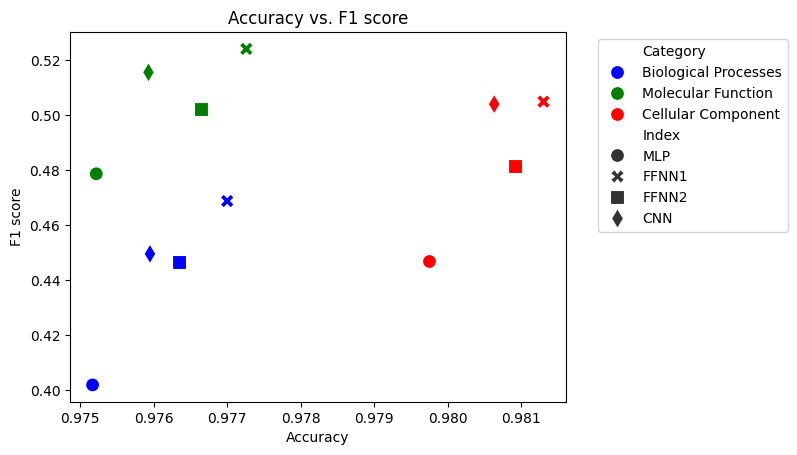

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the DataFrame
results = {
    'Biological Processes': [(0.97700, 0.46873), (0.97634, 0.44645), (0.97550, 0.42391), (0.97595, 0.44951), (0, 0)],
    'Molecular Function': [(0.97726, 0.52399), (0.97665, 0.50205), (0.97581, 0.47844), (0.97593, 0.51548), (0, 0)],
    'Cellular Component': [(0.98130, 0.50483), (0.98091, 0.48136), (0.97989, 0.45681), (0.98063, 0.50392), (0, 0)]
    # note tuples are of the format (Accuracy, F1 score)
}

results_df = pd.DataFrame(results, index=['FNN1', 'FNN2', 'FNN3', 'CNN', 'RNN'])

# Reshape the DataFrame to long format
results_df = results_df.stack().reset_index()
results_df.columns = ['Index', 'Category', 'Value']
results_df[['Accuracy', 'F1 Score']] = pd.DataFrame(results_df['Value'].tolist(), index=results_df.index)

# Map indices to marker styles
marker_styles = {'FNN1': 'X', 'FNN2': 's', 'FNN3': 'o', 'CNN': '^', 'RNN': 'P'}

# Map categories to colors
colors = sns.color_palette("hls", 5)
category_colors = {'Biological Processes': 'b', 'Molecular Function': 'g', 'Cellular Component': 'r'}

# Plot the scatterplot
sns.scatterplot(data=results_df, x='Accuracy', y='F1 Score', hue='Category', style='Index', palette=category_colors,
                markers=marker_styles, s=100)

plt.xlabel('Accuracy')
plt.ylabel('F1 score')
plt.title('Accuracy vs. F1 score')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('Accuracy vs F1 Score', bbox_inches='tight')
plt.show()

### Visualizing Different Architectures

In [ ]:
!pip install visualkeras

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

In [ ]:
import visualkeras

In [ ]:
FFNNmodel1 = tf.keras.models.load_model(
    '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/bio_data/FFNNMod1/best_BP_model'
)

visualkeras.layered_view(FFNNmodel1, legend=True, to_file='FFNNmodel1.png').show() # write and show

In [ ]:
FFNNmodel2 = tf.keras.models.load_model(
    '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/bio_data/FFNNMod2/best_BP_model'
)

visualkeras.layered_view(FFNNmodel2, legend=True, to_file='FFNNmodel2.png').show() # write and show

In [ ]:
CNNmodel1 = tf.keras.models.load_model(
    '/content/drive/MyDrive/ColabNotebooks/BiologicalData/Final_Project/bio_data/CNNMod1/best_BP_model'
)

visualkeras.layered_view(CNNmodel1, legend=True, to_file='CNNmodel1.png').show() # write and show

In [ ]:
INPUT_SHAPE = (1024, 1)
num_labels = 1500
num_filters = 32
size_kernel = 64

model1 = tf.keras.Sequential([
          tf.keras.layers.BatchNormalization(input_shape = INPUT_SHAPE),
          tf.keras.layers.Conv1D(filters = num_filters, kernel_size = size_kernel, activation = 'relu'),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(units = 512, activation = 'relu'),
          tf.keras.layers.Dense(units = num_labels, activation = 'sigmoid')
          ])

In [ ]:
visualkeras.layered_view(model1, to_file='1.png')

In [ ]:
CNNmodel1.summary()